In [1]:
from __future__ import division

import threading
import random
import dubins
import time
import math
import sys
import os

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

sys.path.append(os.path.abspath('..'))

In [2]:
from mule.low_control import MuleController
from mule.bridge import TCPMule

controller = MuleController()

mule = TCPMule(controller.update)

update_callback = None

def update_function():
    for timestep, _ in enumerate(mule.run()):
        if update_callback:
            update_callback()

        controller.update(mule)

t = threading.Thread(target=update_function)
t.start()

In [3]:
turning_radius = 2
node_length = 5
neighbourhood_size = 5
step_size = 0.1

In [4]:
class Point(object):
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = normalize_angle(theta)
    
    def as_tuple(self):
        return (self.x, self.y, self.theta)

def normalize_angle(theta):
    return math.atan2(math.sin(theta), math.cos(theta))

In [5]:
# Utilities

def collides_with_obstacle(obstacle, point):
    x_dist = math.fabs(obstacle['center'][0] - point.x)
    y_dist = math.fabs(obstacle['center'][2] - point.y)
    
    x_collision = x_dist < (obstacle['extents'][0] + 1.5)
    y_collision = y_dist < (obstacle['extents'][2] + 1.5)

    return x_collision and y_collision

def collides_with_obstacles(point):
    blockers = [obj for obj in mule.detectedObjects if obj['type'] == 'Blocker']

    for blocker in blockers:
        if collides_with_obstacle(blocker, point):
            return True
    
    return False

def distance(p1, p2):
    return dubins.path_length(p1.as_tuple(), p2.as_tuple(), turning_radius)

In [6]:
# Sample a random point

def rrt_sample_free():
    while True:
        sample = Point(random.uniform(4, 0), random.uniform(20, 0), 2 * math.pi * random.random())

        if not collides_with_obstacles(sample):
            return sample


In [7]:
# Maintain graph

def rrt_add_node(end, start):
    rrt_graph[end] = []
    rrt_graph[start].append(end)
    rrt_parent[end] = start
    rrt_cost[end] = rrt_cost[start] + distance(start, end)

def rrt_path(current):
    path = [current]
    
    if current not in rrt_parent:
        current = rrt_nearest_neighbour(current)
        path.append(current)

    while current in rrt_parent:        
        current = rrt_parent[current]

        path.append(current)

    return path

def rrt_nearest_neighbour(x_rand):
    min_dist = 100000
    
    closest = None

    for node in rrt_graph.keys():
        dist = distance(node, x_rand)
        
        if dist < min_dist:
            min_dist = dist
            closest = node
    
    return closest

def rrt_neighbourhood(x_rand):
    neighbourhood = []

    for node in rrt_graph:
        if distance(x_rand, node) <= neighbourhood_size:
            neighbourhood.append(node)

    return neighbourhood


In [8]:
# Is the path collsion free

def rrt_obstacle_free(start, end):
    qs, _ = dubins.path_sample(start.as_tuple(), end.as_tuple(), turning_radius, step_size)

    for x, y, phi in qs:
        if collides_with_obstacles(Point(x, y, 0)):
            return False
        
        if (x > 4)  or (x < 0):
            return False

        if (y > 20) or (y < -5):
            return False

    return True

# Steer start towards end

def rrt_steer(start, end):
    if distance(start, end) < node_length:
        return end
        theta = math.atan2(start.x - end.x, start.y - end.y)
        return Point(start.x, start.y, theta)
    else:
        theta = math.atan2(start.x - end.x, start.y - end.y)
        x = start.x + node_length * math.cos(theta)
        y = start.y + node_length * math.sin(theta)
#         return Point(x, y, theta)
        return Point(x, y, end.theta)

In [9]:
# The RRT algorithm

def rrt_step():
    x_rand = rrt_sample_free()
    x_nearest = rrt_nearest_neighbour(x_rand)
    x_new = rrt_steer(x_nearest, x_rand)

    if rrt_obstacle_free(x_nearest, x_new):
        X_near = rrt_neighbourhood(x_new)

        x_min = x_nearest
        c_min = rrt_cost[x_nearest] + distance(x_nearest, x_new)

        for x_near in X_near:
            if rrt_obstacle_free(x_near, x_new) and (rrt_cost[x_near] + distance(x_near, x_new) < c_min):
                x_min = x_near
                c_min = rrt_cost[x_near] + distance(x_near, x_new)

        rrt_add_node(x_new, x_min)

        for x_near in X_near:
            if rrt_obstacle_free(x_near, x_new) and (rrt_cost[x_new] + distance(x_near, x_new) < rrt_cost[x_near]):
                rrt_parent[x_near] = x_new


In [10]:
random.seed(time.time())

start = Point(mule.sensorData['position_x'], mule.sensorData['position_z'], math.radians(90 - mule.sensorData['rot_y']))
end = Point(0, 20, math.radians(90))

rrt_graph = {start: []}
rrt_parent = {}
rrt_cost = {start: 0}

for _ in range(0, 1000):
    rrt_step()

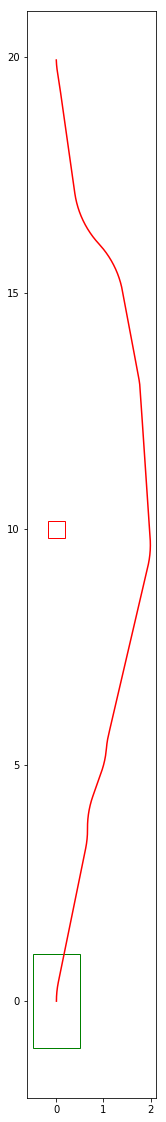

In [11]:
fig, ax = plt.subplots(1, figsize=(20, 20))

for detectedObject in mule.detectedObjects:
    if detectedObject['type'] != 'Blockers':
        continue
    
    xy = (
        detectedObject['center'][0] - detectedObject['extents'][0],
        detectedObject['center'][2] - detectedObject['extents'][2],
    )
    
    width  = detectedObject['extents'][0] * 2
    height = detectedObject['extents'][2] * 2

    ax.add_patch(Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none'))

mule_xy = (
    mule.sensorData['position_x'] - 0.5, 
    mule.sensorData['position_z'] - 1,
)

ax.add_patch(Rectangle(mule_xy, 1, 2, linewidth=1,edgecolor='g',facecolor='none'))

ax.set_aspect('equal')

# for start, tos in rrt_graph.iteritems():
#     for to in tos:
#         qs, _ = dubins.path_sample(start.as_tuple(), to.as_tuple(), turning_radius, step_size)

#         plt.plot([q[0] for q in qs], [q[1] for q in qs], color='g')

path = rrt_path(end)

path.reverse()

xs = []
ys = []

us = []
vs = []

raw_waypoints = []

for fro, to in zip(path, path[1:]):
    qs, _ = dubins.path_sample(fro.as_tuple(), to.as_tuple(), turning_radius, step_size)
    qs2, _ = dubins.path_sample(fro.as_tuple(), to.as_tuple(), turning_radius, 1)

    xs += [q[0] for q in qs]
    ys += [q[1] for q in qs]
    
    us += [math.cos(q[2]) for q in qs]
    vs += [math.sin(q[2]) for q in qs]

    raw_waypoints += qs2

# plt.plot([x.x for x in path], [x.y for x in path], color='r')
plt.plot(xs, ys, color='r')
# plt.quiver(xs, ys, us, vs)
plt.show()

In [12]:
class PPoint(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

def distance(a, b):
    dist2 = (a.x - b.x) ** 2 + (a.y - b.y) **2

    return math.sqrt(dist2)

def subtract(a, b):
    return PPoint(a.x - b.x, a.y - b.y)

def rotate(v, theta):
    return PPoint(v.x * math.cos(theta) - v.y * math.sin(theta), v.x * math.sin(theta) + v.y * math.cos(theta))

# Pure pursuit code

def pure_pursuit(vehicle_position, vehicle_rotation, anchor):
    anchor = subtract(anchor, vehicle_position)
    anchor = rotate  (anchor, vehicle_rotation)

    r = (anchor.x**2 + anchor.y**2)/(2 * anchor.x)

    v = min(3, math.sqrt(4 * math.fabs(r)))

    return v, r

waypoints = []
closest_waypoint_ = [0]

for x in range(0, len(raw_waypoints)):
    waypoints.append(PPoint(raw_waypoints[x][0], raw_waypoints[x][1]))

def pure_pursuit_callback():
    closest_waypoint = closest_waypoint_[0]

    vehicle_position = PPoint(mule.sensorData['position_x'], mule.sensorData['position_z'])
    vehicle_rotation = math.radians(mule.sensorData['rot_y'])

    # Update closest waypoint
    distance_min = distance(vehicle_position, waypoints[closest_waypoint])

    for i in range(closest_waypoint + 1, len(waypoints)):
        new_dist = distance(vehicle_position, waypoints[i])

        if new_dist < distance_min:
            closest_waypoint = i

            distance_min = new_dist
        else:
            break

    # Get anchors

    rotation_anchor = None

    lookahead = 3

    for i in range(closest_waypoint + 1, len(waypoints)):
        if distance(vehicle_position, waypoints[i]) > lookahead:
            rotation_anchor = waypoints[i]
            break

    if rotation_anchor is None:
        controller.desired_omega = 0
        controller.desired_velocity = 0
        controller.brake_input = 0.1
        
        return

    # mule.add_marker(rotation_anchor.x, rotation_anchor.y)

    v, r = pure_pursuit(vehicle_position, vehicle_rotation, rotation_anchor)

    controller.desired_velocity = v
    controller.desired_omega = math.degrees(v/r)
        
    closest_waypoint_[0] = closest_waypoint


In [13]:
update_callback = pure_pursuit_callback

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-2-5361609e6f97>", line 11, in update_function
    for timestep, _ in enumerate(mule.run()):
  File "/Users/saad/Documents/Projects/ProjectMule/mule/mule/bridge.py", line 108, in run
    data = self.recv_bus_reqs()
  File "/Users/saad/Documents/Projects/ProjectMule/mule/mule/bridge.py", line 140, in recv_bus_reqs
    req = self.recv_bus_req()
  File "/Users/saad/Documents/Projects/ProjectMule/mule/mule/bridge.py", line 153, in recv_bus_req
    var = self.decode_bus_var(raw_var)
  File "/Users/saad/Documents/Projects/ProjectMule/mule/mule/bridge.py", line 202, in decode_bus_v

In [43]:
update_callback = None
controller.reset(mule)

In [14]:
def mule_side(mule, side):
    if side == 'fr':
        vehicle_coordinates = [ 1,  0.5]
    elif side == 'fl':
        vehicle_coordinates = [ 1, -0.5]
    elif side == 'rr':
        vehicle_coordinates = [-1,  0.5]
    elif side == 'rl':
        vehicle_coordinates = [-1, -0.5]
    
    global_coordinates = [
        vehicle_coordinates[0] * math.cos(mule.theta) - vehicle_coordinates[1] * math.sin(mule.theta) + mule.x,
        vehicle_coordinates[0] * math.sin(mule.theta) + vehicle_coordinates[1] * math.cos(mule.theta) + mule.y,
    ]
    
    return global_coordinates


In [58]:
mule_pos_1 = Point(1, 0, math.radians(0))

mule_sides_1 = [
    mule_side(mule_pos_1, 'fr'),
    mule_side(mule_pos_1, 'fl'),
    mule_side(mule_pos_1, 'rl'),
    mule_side(mule_pos_1, 'rr'),
    mule_side(mule_pos_1, 'fr'),
]

mule_pos_2 = Point(4, 4, math.radians(90))

mule_sides_2 = [
    mule_side(mule_pos_2, 'fr'),
    mule_side(mule_pos_2, 'fl'),
    mule_side(mule_pos_2, 'rl'),
    mule_side(mule_pos_2, 'rr'),
    mule_side(mule_pos_2, 'fr'),
]

motion_polygon = [
    mule_side(mule_pos_1, 'rl'),
    mule_side(mule_pos_1, 'rr'),
    mule_side(mule_pos_2, 'fr'),
    mule_side(mule_pos_2, 'fl'),
]

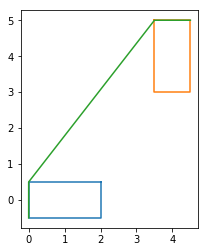

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([x[0] for x in mule_sides_1], [x[1] for x in mule_sides_1])
ax.plot([x[0] for x in mule_sides_2], [x[1] for x in mule_sides_2])
ax.plot([x[0] for x in motion_polygon], [x[1] for x in motion_polygon])

ax.set_aspect('equal')
